In [1]:
import pickle
from random import shuffle, seed
import numpy as np
from util import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore') # get rid of silly sklearn warnings

seed("sahai uwu")

In [5]:
ppath = "/Volumes/scottd/mimic_processed/preproced.bin"
#ppath = "/Volumes/scottd/mimic_processed/preproced_discharge.bin"
data = pickle.load(open(ppath, 'rb')) # Tuples of (text, label) where label is 0 or 1
shuffle(data)

split_point = int(0.8 * len(data)) # Use 80% of our data for training and the rest for testing
train = data[:split_point]
test = data[split_point:]

train_data = [t[0] for t in train]
train_labels = [t[1] for t in train]
test_data = [t[0] for t in test]
test_labels = [t[1] for t in test]

print("Number of training samples: " + str(len(train)))
print("Number of test samples: " + str(len(test)))
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

Number of training samples: 5655
Number of test samples: 1414
(array([0, 1]), array([3355, 2300]))
(array([0, 1]), array([846, 568]))


Accuracy: 0.8628005657708628


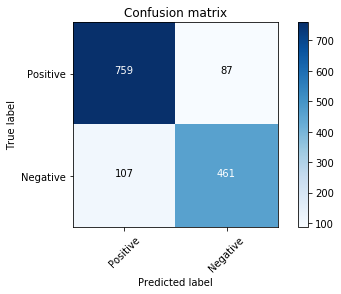

0.10283687943262411
0.8116197183098591
[0.40169731 0.84124088 1.        ]
[1.         0.81161972 0.        ]


In [12]:
# The first classification technique we will try is SVM on TF-IDF vectors
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

classifier = make_pipeline(CountVectorizer(ngram_range=(2,2)), TfidfTransformer(), SGDClassifier(loss='hinge', penalty='l2', alpha=0.0005, max_iter=100)) 
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

fpr, tpr, _ = roc_curve(test_labels, predictions, pos_label=1)
print(fpr[1])
print(tpr[1])

precision, recall, _ = precision_recall_curve(test_labels, predictions)
print(precision)
print(recall)



['normal' 'infant' 'term' 'nicu' 'screen' 'sepsis' 'negex' 'transfer'
 'newborn_nursery' 'delivery' 'distress' 'nbn' 'risk' 'term infant'
 'maternal' 'grunting' 'cbc' 'admission' 'female' 'admission note' 'wt'
 'cckgday' 'cpap' 'spits' '' 'caffeine' 'spells' 'phototherapy' 'shift'
 'voiding' 'isolette' 'monitor' 'tf' 'remains' 'support' 'cares'
 'continue' 'cont' 'feeds' 'bili']


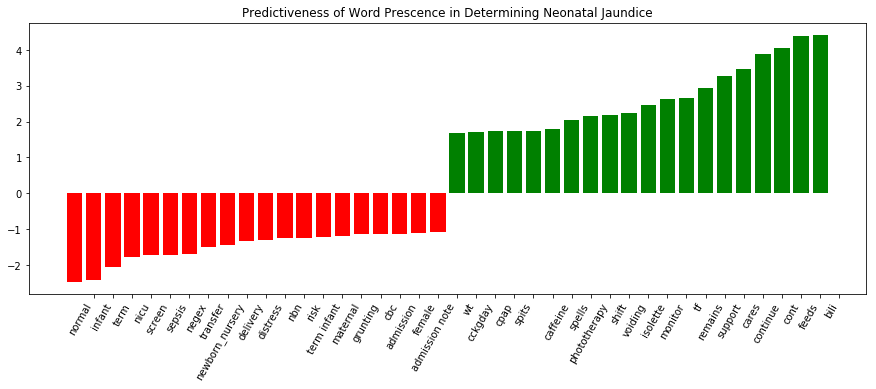

In [10]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'green' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    print(feature_names[top_coefficients])
    plt.title('Predictiveness of Word Prescence in Determining Neonatal Jaundice')
    plt.savefig("predictiveness.png")
    plt.show()
    
plot_coefficients(classifier.named_steps['sgdclassifier'], classifier.named_steps['countvectorizer'].get_feature_names())

In [15]:
classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), SGDClassifier(loss='hinge', penalty='l2', alpha=0.0005, max_iter=100)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
print(scores.mean())

classifier = make_pipeline(CountVectorizer(), SGDClassifier(loss='hinge', penalty='l2', alpha=0.0005, max_iter=100)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
print(scores.mean())

0.8845660650852004
0.8487788429125169


Accuracy: 0.8


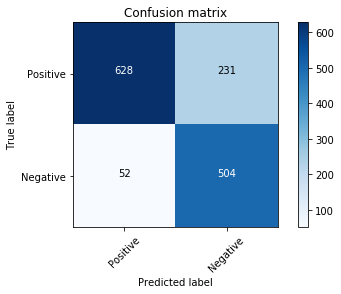

In [4]:
# Next, try k-Nearest Neighbors on TF-IDF vectors
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), KNeighborsClassifier(n_neighbors=5)) 
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), KNeighborsClassifier(n_neighbors=5)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()

Accuracy: 0.8635077793493635


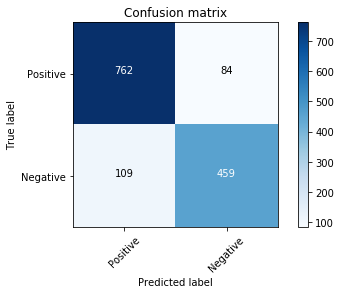

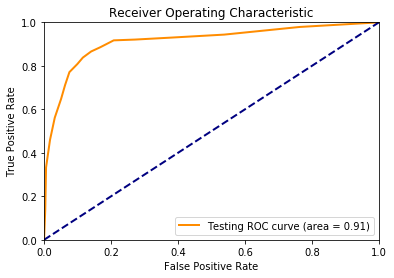

In [ ]:
# Finally, try Random Forests
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), RandomForestClassifier(n_estimators=16)) 
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

class_probs = classifier.predict_proba(test_data)
conf = [c[1] for c in class_probs]

fpr, tpr, thresholds = roc_curve(test_labels, conf, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

classifier = make_pipeline(CountVectorizer(ngram_range=(0,2)), TfidfTransformer(), RandomForestClassifier(n_estimators=16)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()